# Using a group convolutional neural network to learn the ground-state of a symmetric spin model

The goal of this tutorial is to learn about group convolutional neural networks (G-CNNs), a useful tool for simulating lattices with high symmetry. The G-CNN is a generalization to the convolutional neural network (CNN) to non-abelian symmetry groups (groups that contain at least one pair of non-commuting elements). G-CNNs are a natural fit for lattices that have both point group and translational symmetries, as rotations, reflections and translations don't commute with one-another.

In this tutorial we will learn the ground state of the antiferromagnetic Heisenberg model on  the honeycomb lattice. The Heisenberg Hamiltonian is defined as follows:

$$ H = \sum_{i,j \in \langle \rangle} \vec{\sigma}_{i} \cdot \vec{\sigma}_{j},$$

where $\vec{\sigma}_{i}$ are Pauli matrices and $<>$ denotes nearest neighbor interactons. 

For this tutorial, many of the calculations will be much faster on a GPU. If you don't have access to a GPU, you can open a [Google Colab](https://colab.research.google.com/) notebook, and set runtime type to GPU.  

This tutorial wil be split into two parts. First I'll provide a brief introduction to G-CNNs and describe what advantages they bring. Second, we'll use NetKet to find the ground state of the antiferromagnetic Heisenberg model on the honeycomb lattice. First we will simulate a lattice with $N=18$ sites in order to compare with exact diagonalization. Then we will simulate a lattice with $N=72$ sites. 

# G-CNNs are generalizations of CNNs to non-abelian groups

The convolutional neural network (CNN) has revolutionized the field of computer vision. The CNN enforces translational invariance, which means that feeding a CNN translated copies of an image will produce the exact same output. This is important for recognizing objects, which may located differently in different images.

The  hidden layers of a CNN contain a group of ${\bf features}$, corresponding to translations of the image, where each feature is represented by a vector. At each layer, the CNN integrates over these features to produce a different set of features over the translation group:

$$ C^i_{x,y} = \sum_h {\bf W}_{x'-x, y'-y} \cdot {\bf f}_{x,y} $$

As you can see, the index of the filter W is based on the displacement between the input feature {x',y'} and the output feature {x, y}. This is known as an equivariant operation, as displacements in the input are propagated as displacements in the output (equivariance is actually bit more general, we'll get to that in a moment). In the last layer, the CNN averages over these different features, forcing the output to be invariant to the input. 

To generalize the CNN to the G-CNN, lets abstract away from the specifics of the convolution. Instead of indexing the features with translations, we will use elements from a general symmetry group which may contain non-commmuting operations. In this case we must define a particular order of operations. For example, we could define an operation in the $p6m$ space group, as a translation, followed by a rotation and a reflection about the origin. Non-abelian groups still maintain associativity and a closed algebra. This is easy to see with lattice symmetry groups. If two successive symmetry operations leave the lattice unchanged, applying both must also leave the lattice unchanged and therefore be symmetry operation in the group. 

For G-convolutions, the building blocks of the G-CNN, this algebra is all we need. The G-convolution also indexes the filters by looking at the "difference" between group elements, however this time there is an orientation to it. The G-convolution is defined as follows: 

$$ C^i_g = \sum_h {\bf W}_{g^{-1} h} \cdot {\bf f}_h $$

The filters are indexed by $g^{-1} h$, which describes the mapping from $g \rightarrow h$ but not vice-versa. This causes the output to be an ${\bf involution}$ of the input, meaning that the group elements are mapped to their respective inverses.

G-convolutions are the most expressive linear transformation over a particular symmetry group. Therefore, if you want to define a linear-based model with a particular symmetry, G-CNNs maximize the number of parameters you can fit into a given memory profile. G-CNNs can be mapped down to other symmetry-averaged multi-layer linear models by masking filters (setting them to zero). On the Honeycomb lattice, the G-CNN (approximately) has a factor of 12 more parameters than a CNN averaged over $d_6$ and a factor of $12 N$ more parameters than a feedforward neural network averaged over $p6m$ (where N is the number of sites) under an identical memory constraint. 

If you'd like to learn more about G-CNNs, check out the [original paper](http://proceedings.mlr.press/v48/cohenc16.pdf) by Cohen ${\it et \ al.}$ or [this paper](https://arxiv.org/pdf/2104.05085.pdf) by Roth ${\it et \ al.}$ that applies G-CNNs to quantum many-body systems.

Now that the boring stuff is over with, lets start our simulations. First let's import NetKet and other neccesities 

In [2]:
# Run if you're on Colab or you don't have NetKet installed
# pip install "git+https://github.com/netket/netket#egg=netket[all]"
import netket as nk

# Import Json, this will be needed to examine log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Defining the Hamiltonian

We begin by defining the Hamiltonian as a list of lattice points. NetKet will automatically convert these points into a graph with nearest neighbor connections. The honeycomb lattice is a triangular lattice with two sites per unit cell.

In [4]:
#Basis Vectors that define the positioning of the unit cell
basis_vectors = [[0,1],[np.sqrt(3)/2,-1/2]]

#Locations of atoms within the unit cell
atom_positions = [[0,0],[np.sqrt(3)/6,1/2]]

#Number of unit cells in each direction
dimensions = [3,3]

#Define the graph 
graph = nk.graph.Lattice(basis_vectors=basis_vectors, 
                         atoms_coord = atom_positions, 
                         extent = dimensions
                        )

Lets check to see if our graph looks as expected. Since we have two sites per unit cell, we should have $3 \times 3 \times 2 = 18$ sites. The coordination number of a hexagonal lattice is 3, so we should have $\frac{18 \times 3}{2} = 27$ edges. Finally we have p6m symmetry, which should give ue $3 \times 3 \times 12 = 108$ symmetry operations.

In [9]:
#Use Netket to find symmetries of the graph
symmetries = graph.automorphisms()

#Check that graph info is correct
print(graph.n_nodes)
print(graph.n_edges)
print(len(symmetries))

18
27
216


Oops! It looks like we have twice as many symmetries elements as we thought. Luckily for us, the ground state is still symmetric with respect to this extra symmetry that is unique to the $3 \times 3$ lattice. We use this graph to define our Hilbert space and Hamiltonian:

In [10]:
# Define the Hilbert space
hi = nk.hilbert.Spin(s=1 / 2, N=graph.n_nodes, total_sz = 0)

#Define the Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=graph, sign_rule=True)

Since the Hexagonal lattice is bipartite, we know the phases obey a Marhall-Perels sign rule. Therefore, we can use a real valued NN and just learn the amplitudes of the wavefunction. Furthermore, we know the ground state has total spin 0.

# Defining the GCNN

We can define a GCNN with an arbitrary number of layers and specify the feature dimension of each layer accordingly:

In [11]:
#Feature dimensions of hidden layers, from first to last
feature_dims = (8,8,8,8)

#Number of layers
num_layers = 4

#Define the GCNN 
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)

This a G-CNN with four layers, where each hidden layer contains a feature vector of length 8 for each element in p6m. This means that each hidden state has $8 \times 192 = 768$ nodes. This is a huge model! But since we're not symmetry-averaging, we only need to compute one wavefunction for each ${\bf \sigma}$. 

Feel free to try different shaped models. By default, the GCNN weights are initialized with variance scaling, which ensures that the activations will be unit-normal throughout the model at the start of training. Additionally, GCNN defaults to a SELU non-linearity, which moves the activations in the direction of unit-normal, even when they start to deviate. These features ensure that our model will behave well, even when we stack a large number of layers.   

# Variational Monte Carlo

In order to perform VMC we need to define a sampler and an optimizer. We sample using Metropolis-Hastings, which uses the exchange rule to propose new states. The exchange rule swaps the spin of two neighbouring sites, keeping the magnetization fixed (in this case, 0). We optimize uzing stochaistic reconfiguration, which uses curvature information to find the best direction of descent.

In [12]:
#Metropois-Hastings with two spins flipped that are at most second nearest neighbors 
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=graph, d_max=2)

#Stochaistic reconfiguration   
op = nk.optimizer.Sgd(learning_rate=1e-2)
sr = nk.optimizer.SR(diag_shift=0.01)

#Define a variational state so we can keep the parameters if we like
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=100)

#Define a driver that performs VMC
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)

Lets start by running for 100 iterations. If you're on a CPU this will take ~15 seconds per iteration, on a GPU it will take 1 second per iteration. GPUs are fast! As you'll see later, the speedup is even more pronounced on larger lattices.  

In [15]:
#Run the optimization
gs.run(n_iter=100, out='out')

100%|██████████| 100/100 [01:06<00:00,  1.51it/s, Energy=-40.471 ± 0.046 [σ²=0.238, R̂=0.9744]]


(<netket.logging.json_log.JsonLog at 0x7fea898371d0>,)

This should get us under 0.1% error. Lets see how the energy evolves as we train.

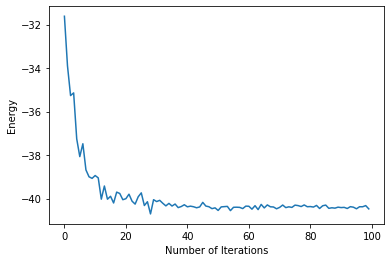

In [16]:
#Get data from log and 
energy = []
data=json.load(open("out.log"))
for en in data["Energy"]["Mean"]:
    energy.append(en)
    
#plot the energy during the optimization
plt.xlabel("Number of Iterations")
plt.ylabel("Energy")

plt.plot(energy)

Looks like the first 40 iterations did most of the work! In order to get a more precise estimate, we can run 100 more iterations with a larger batch size. This will take about 15 minutes on the GPU (If you're using a CPU, I suggest you skip this section). We access the batch size via the variational state. 

In [17]:
#Change batch size
vstate.n_samples = 1000

#Driver uses new batch size
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)

#Run for 100 more iterations
gs.run(n_iter = 100,out = 'out')

100%|██████████| 100/100 [10:43<00:00,  6.43s/it, Energy=-40.3884 ± 0.0045 [σ²=0.0207, R̂=1.0033]]


(<netket.logging.json_log.JsonLog at 0x7fe6a31f2d90>,)

You will notice that the variance continues to get even smaller, giving evidence that we are nearing an eigenstate.  

# Checking with ED

It seems likely that our ground state is correct, as we approached an eigenstate with low energy, but lets be safe and check our work. We can do Lanczos diagonalization for small lattices in NetKet.  

In [18]:
#Exact Diagonalization
E_gs = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)

Lets compare the VMC energy with the ED energy, by taking average energy over the last $20$ iterations

In [19]:
#Get data from larger batch size
energy = []
data=json.load(open("out.log"))
for en in data["Energy"]["Mean"]:
    energy.append(en)

vmc_energy_18sites = np.mean(np.asarray(energy)[-20:])/18

ED_energy_18sties = E_gs[0]/18

print(vmc_energy_18sites)
print(ED_energy_18sties)
print((ED_energy_18sties- vmc_energy_18sites)/ED_energy_18sties)

-2.2437762156893766
-2.243814630334411
1.7120240021148795e-05


Looks like our model did a good job! If you just trained for the first 100 iterations the error should be less than $10^{-4}$ and if you trained with the larger batch size, the error should be close to $10^{-5}$

# Simulating A Larger Lattice

Lets see how the GCNN does on a larger lattice that cannot be simulated with exact diagonalization. We'll do a $6 \times 6$ lattice which has $72$ sites. We need to redefine a few things:

In [20]:
#Redefine bigger graph
dimensions = [6,6]

#Define the graph 
graph = nk.graph.Lattice(basis_vectors=basis_vectors, 
                         atoms_coord = atom_positions, 
                         extent = dimensions
                        )
# Redefine the Hilbert/Hamiltonian for larger lattice space
hi = nk.hilbert.Spin(s=1 / 2, N=graph.n_nodes, total_sz = 0)
ha = nk.operator.Heisenberg(hilbert=hi, graph=graph, sign_rule=True)

# Compute the symmetries for the bigger graph 
symmetries = graph.automorphisms()
print(len(symmetries))

#Redefine everything on bigger graph
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=graph, d_max=2)
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=100, n_discard=100)
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)

432


Looks like we have no extra symmetries this time, as $6 \times 6 \times 12 = 432$. Lets run this bigger model for 100 iterations. This should take about a 20 minutes to an hour to run on Colab, depending on what GPU you are assigned.

In [21]:
#Run for 100 iterations
gs.run(n_iter = 100,out = "out")

100%|██████████| 100/100 [20:33<00:00, 12.33s/it, Energy=-155.02 ± 0.52 [σ²=30.26, R̂=1.0333]]


(<netket.logging.json_log.JsonLog at 0x7fe69eacdd50>,)

We can plot the energy and variance to see if the model seems converged:

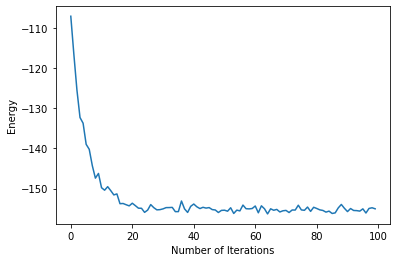

In [22]:
data=json.load(open("out.log"))

energy = []
for en in data["Energy"]["Mean"]:
    energy.append(en)

plt.xlabel("Number of Iterations")
plt.ylabel("Energy")
plt.plot(energy)

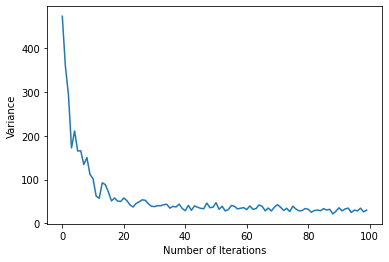

In [23]:
variance = []
for var in data["Energy"]["Variance"]:
    variance.append(var)

plt.xlabel("Number of Iterations")
plt.ylabel("Variance")
plt.plot(variance)

Looks like the energy is asymptoting and the variance is headed towards zero. We can compute the energy and standard deviation per site using the last $2000$ samples

In [24]:
en_per_site = np.mean(energy[-20:])/graph.n_nodes
stdev_per_site = np.sqrt(np.mean(variance[-10:])/100)/graph.n_nodes
print(en_per_site)
print(stdev_per_site)

-2.156913717017429
0.0076993113895388356


Based on the standard deviation, it looks like our wavefunction has on the order of 1% error. Not bad for 20 minutes of training!

You may notice that the energy per site is slightly smaller (in magnitude) for the larger lattice. This is expected, as it's something that generally holds true for Heisenberg models on periodic lattices. 

This concludes the tutorial. Only an hour ago we knew nothing about the Heisenberg model on a Hexagonal lattice. Now we have an accurate approximation of the ground state wavefunction!